Number of rows (n): 5
Mean value: 711.8313547619047
Sample standard deviation (ddof=1): 107.23997619386544
Overall SEM: 47.95917533498846


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_17368/3855389975.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap      = plt.cm.get_cmap('tab10', len(ids))


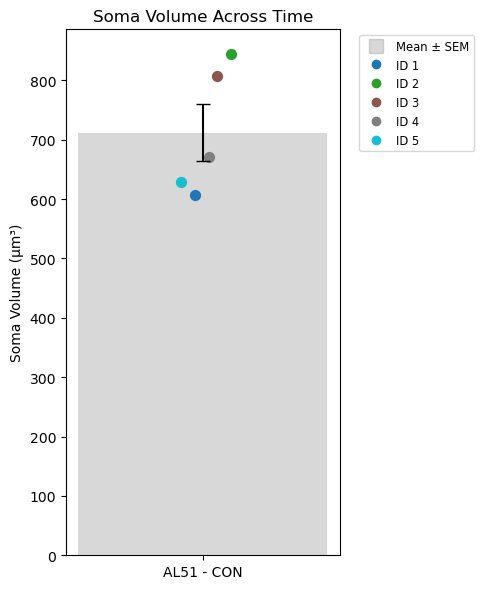

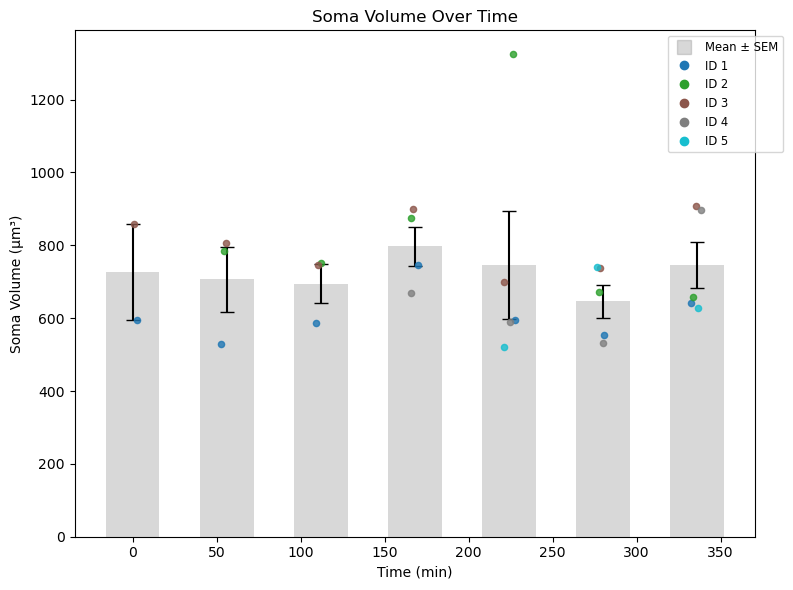

In [22]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === User‐defined parameters ===
#INPUT for filament data you are interested in 
FILE_PATH       = "/Users/alexlawson/Masters-Data-Final/Live-imaging/Results/Statistics/Combined Stats/CON/Unknown/AL51/Soma_Volume.csv"
ID_COL          = "MicrogliaID"
VALUE_COL       = "Soma Volume"  # or "AvgPrimaryBranchLength" for average length
FRAME_COL       = "Frame"
TIME_PER_FRAME  = 8    # minutes per frame
XTICK_LABEL     = "AL51 - CON"
Y_LABEL         = "Soma Volume (µm³)"  # or "Average Length (µm)" for average length µm³
PLOT_TITLE      = "Soma Volume"  # or "Average Primary Branch Length" for average length
SAVE_PATH       = None # e.g. "output.png" to save, or None to display

# make jitter reproducible (optional)
np.random.seed(42)

def plot_microglia():
    # 1) Load & clean
    df = pd.read_csv(FILE_PATH)
    df = df.dropna(subset=[ID_COL, VALUE_COL, FRAME_COL])

    # 2) Compute actual time for each measurement
    df['Time'] = df[FRAME_COL].astype(float) * TIME_PER_FRAME

    # 3) Prepare color map for IDs
    ids       = sorted(df[ID_COL].unique())
    cmap      = plt.cm.get_cmap('tab10', len(ids))
    color_dict= {mid: cmap(i) for i, mid in enumerate(ids)}

    # ---- Plot 1: Overall mean ± SEM + per-cell means ----
    df_means     = df.groupby(ID_COL)[VALUE_COL].mean().reset_index()
    overall_mean = df_means[VALUE_COL].mean()
    overall_sem  = df_means[VALUE_COL].std(ddof=1) / np.sqrt(len(df_means))

    print("Number of rows (n):", len(df_means))
    print("Mean value:", df_means[VALUE_COL].mean())
    print("Sample standard deviation (ddof=1):", df_means[VALUE_COL].std(ddof=1))

    overall_sem = df_means[VALUE_COL].std(ddof=1) / np.sqrt(len(df_means))
    print("Overall SEM:", overall_sem)


    fig1, ax1 = plt.subplots(figsize=(5,6))
    bar_center = 1
    bar_width1 = 0.3

    # mean ± SEM bar
    ax1.bar(
        bar_center,
        overall_mean,
        width=bar_width1,
        yerr=overall_sem,
        capsize=5,
        alpha=0.3,
        color='grey',
        label='Mean ± SEM'
    )

    # uniform jitter within the bar
    x_jitter1 = bar_center + np.random.uniform(-bar_width1/8, bar_width1/8, size=len(df_means))
    for i, row in df_means.iterrows():
        ax1.scatter(
            x_jitter1[i],
            row[VALUE_COL],
            color=color_dict[row[ID_COL]],
            s=50
        )

    ax1.set_xticks([bar_center])
    ax1.set_xticklabels([XTICK_LABEL])
    ax1.set_ylabel(Y_LABEL)
    ax1.set_title(f"{PLOT_TITLE} Across Time")

    handles1 = [
        plt.Line2D([0],[0], marker='s', color='grey', label='Mean ± SEM',
                   alpha=0.3, markersize=10, linestyle='None')
    ] + [
        plt.Line2D([0],[0], marker='o', color=color_dict[mid], label=f'ID {mid}',
                   markersize=6, linestyle='None') for mid in ids
    ]
    ax1.legend(handles=handles1, bbox_to_anchor=(1.05,1), fontsize='small')
    plt.tight_layout()

    # ---- Plot 2: Time series mean±SEM bars + jittered individual points ----
    summary   = df.groupby('Time')[VALUE_COL].agg(['mean','sem']).reset_index()
    time_diff = summary['Time'].diff().median()
    bar_width2 = 4.0 * float(TIME_PER_FRAME)

    fig2, ax2 = plt.subplots(figsize=(8,6))
    # mean±SEM bars
    ax2.bar(
        summary['Time'],
        summary['mean'],
        width=bar_width2,
        yerr=summary['sem'],
        capsize=5,
        alpha=0.3,
        color='grey',
        zorder=1,
        label='Mean ± SEM'
    )

    # uniform jitter per-ID
    for mid in ids:
        grp    = df[df[ID_COL] == mid]
        x_base = grp['Time'].values
        x_j    = x_base + np.random.uniform(-bar_width2/8, bar_width2/8, size=len(x_base))
        ax2.scatter(
            x_j,
            grp[VALUE_COL].astype(float).values,
            s=20,
            alpha=0.8,
            color=color_dict[mid],
            zorder=2
        )

    ax2.set_xlabel('Time (min)')
    ax2.set_ylabel(Y_LABEL)
    ax2.set_title(f"{PLOT_TITLE} Over Time")

    handles2 = [
        plt.Line2D([0],[0], marker='s', color='grey', label='Mean ± SEM',
                   alpha=0.3, markersize=10, linestyle='None')
    ] + [
        plt.Line2D([0],[0], marker='o', color=color_dict[mid], markerfacecolor=color_dict[mid], label=f'ID {mid}',
                   markersize=6, linestyle='None') for mid in ids
    ]
    ax2.legend(handles=handles2, bbox_to_anchor=(1.05,1), fontsize='small')
    plt.tight_layout()

    # ---- Save or show ----
    if SAVE_PATH:
        base, ext = os.path.splitext(SAVE_PATH)
        fig1.savefig(f"{base}_mean{ext}", dpi=300)
        fig2.savefig(f"{base}_time{ext}", dpi=300)
        print(f"Saved figures to {base}_mean{ext} and {base}_time{ext}")
    else:
        plt.show()

if __name__ == "__main__":
    plot_microglia()
